In [1]:
%run tools.ipynb

### play with NN model

In [2]:
# --- import necessary libraries

from xenonpy.model.nn import Layer1d
from torch.nn import Sequential

In [91]:
# --- build nn regression model

def Net(n_feature, n_hidden1, n_hidden2, n_hidden3, n_output):
    return Sequential(
        Layer1d(n_in=n_feature, n_out=n_hidden1), 
        Layer1d(n_in=n_hidden1, n_out=n_hidden2),
        Layer1d(n_in=n_hidden2, n_out=n_hidden3),
        Layer1d(n_in=n_hidden3, n_out=n_output, act_func=None, batch_nor=None)
    ) 

nn_model = Net(
    n_feature=290,
    n_hidden1=200,
    n_hidden2=100,
    n_hidden3=30,
    n_output=1)

In [55]:
# --- check model

nn_model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=200, bias=True)
    (batch_nor): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (1): Layer1d(
    (layer): Linear(in_features=200, out_features=100, bias=True)
    (batch_nor): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (2): Layer1d(
    (layer): Linear(in_features=100, out_features=30, bias=True)
    (batch_nor): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (3): Layer1d(
    (layer): Linear(in_features=30, out_features=1, bias=True)
  )
)

# Model training

In [90]:
from xenonpy.model.nn.training import Trainer, SGD, MSELoss, Adam, Validator, ReduceLROnPlateau, ExponentialLR
from xenonpy.model.nn.utils import to_tensor
from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

In [6]:
data = preset.mp_inorganic
data = data.sample(3000)
data.head(5)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,has_bandstructure,is_hubbard,is_ordered,n_elemets,nsites,oxide_type,point_group,pretty_formula,space_group,space_group_number,total_magnetization,volume
mp-623460,0.0000,"{'Gd': 2.0, 'Sn': 6.0}",7.143962,0.156264,NaN,"[Gd, Sn]",-6.837039,-0.305910,False,False,True,2,8,None,mm2,GdSn3,Amm2,38,6.954095,238.659595
mp-1096641,0.0000,"{'Be': 2.0, 'Tc': 1.0, 'Pt': 1.0}",0.931282,3.119403,NaN,"[Be, Pt, Tc]",-3.223253,2.751879,False,False,True,3,4,None,mmm,Be2TcPt,Immm,71,3.632856,554.727154
mp-1177283,0.0000,"{'Li': 8.0, 'Ti': 8.0, 'V': 8.0, 'Cr': 2.0, 'O...",3.713314,0.121078,NaN,"[Cr, Li, O, Ti, V]",-7.695924,-2.771379,False,True,True,5,62,oxide,mmm,Li4Ti4V4CrO18,Pbam,55,5.999998,682.389636
mp-1192205,1.1363,"{'K': 2.0, 'Ho': 4.0, 'Cu': 6.0, 'Se': 10.0}",6.358203,0.007899,NaN,"[Cu, Ho, K, Se]",-4.754967,-1.117527,False,False,True,4,22,None,mmm,KHo2Cu3Se5,Cmcm,63,0.000008,498.509849
mp-1218169,2.6707,"{'Sr': 4.0, 'Pr': 4.0, 'In': 4.0, 'O': 16.0}",6.051357,0.036212,NaN,"[In, O, Pr, Sr]",-6.667822,-2.931411,False,False,True,4,28,oxide,222,SrPrInO4,P2_12_12_1,19,0.000000,447.112496


In [7]:
desc = Compositions(featurizers='classic').transform(data['composition']).astype('float32')
prop = data['volume'].to_frame().astype('float32')

desc.head(5)
prop.head(5)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-623460,53.500000,166.250000,255.250000,17.200001,128.345001,2792.000000,53.000000,1121.250000,153.250000,147.250000,...,2.0,5.0,0.222,11.00000,217.0,242.0,259.0,336.799988,2500.0,6.280
mp-1096641,32.250000,124.750000,227.250000,6.900000,77.753891,3934.000000,173.599426,459.250000,118.750000,113.750000,...,1.0,2.0,0.133,51.00000,153.0,198.0,223.0,274.500000,2680.0,5.600
mp-1177283,11.612904,145.342758,200.870972,12.497742,24.612003,1221.968384,85.609962,492.567749,99.709679,92.516129,...,1.0,2.0,0.485,0.02658,152.0,150.0,182.0,245.100006,317.5,0.802
mp-1192205,37.272728,152.454544,231.909088,16.954546,86.768356,1844.863647,49.509090,947.909119,143.909088,131.272720,...,1.0,4.0,0.164,0.52000,190.0,182.0,226.0,340.899994,2000.0,3.770
mp-1218169,25.428572,163.972244,213.571426,18.028572,58.191666,1165.108521,69.299652,1099.971436,114.857140,107.857140,...,2.0,2.0,0.192,0.02658,152.0,150.0,182.0,350.000000,317.5,0.802


,volume
mp-623460,238.659592
mp-1096641,554.727173
mp-1177283,682.389648
mp-1192205,498.509857
mp-1218169,447.112488


In [8]:
sp = Splitter(3000)
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [9]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(2400, 290)

(2400, 1)

(600, 290)

(600, 1)

In [100]:
trainer = Trainer(
    model=nn_model,
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
#     lr_scheduler=ExponentialLR(gamma=0.8),
    epochs=1000,
)

trainer.extend(Validator(x_test, y_test))

In [101]:
trainer.fit(x_train=desc, y_train=prop)

100%|██████████| 1000/1000 [01:02<00:00, 15.93it/s]


In [102]:
trainer.losses.head()

,i_epoch,train_loss,test_mae,test_rmse,test_r2
0,1,198.727625,514.563232,782.368774,-1.067145e+06
1,2,198.711667,514.544189,782.147400,-4.772655e+05
2,3,198.619479,514.382141,782.072937,-4.824255e+05
3,4,198.551500,514.352051,781.781555,-2.945636e+05
4,5,198.413375,514.230408,781.671204,-2.484807e+05


# Model testing

In [103]:
y_pred = trainer.predict(x=x_test)

In [104]:
import plotly.express as px

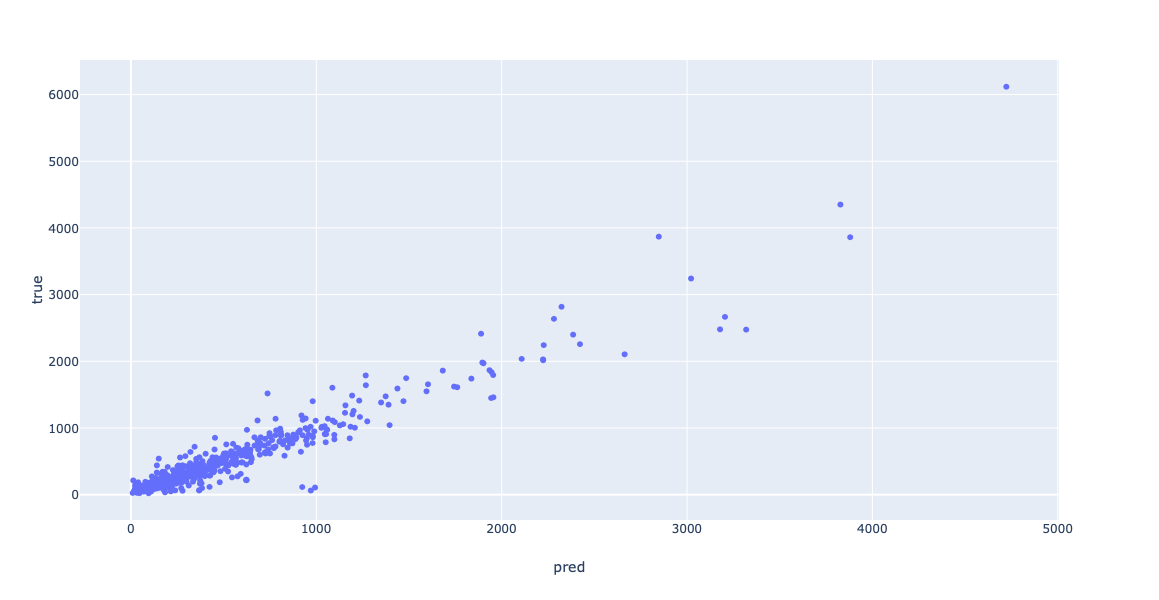

In [105]:
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_test.flatten()}), x='pred', y='true')
fig.show()

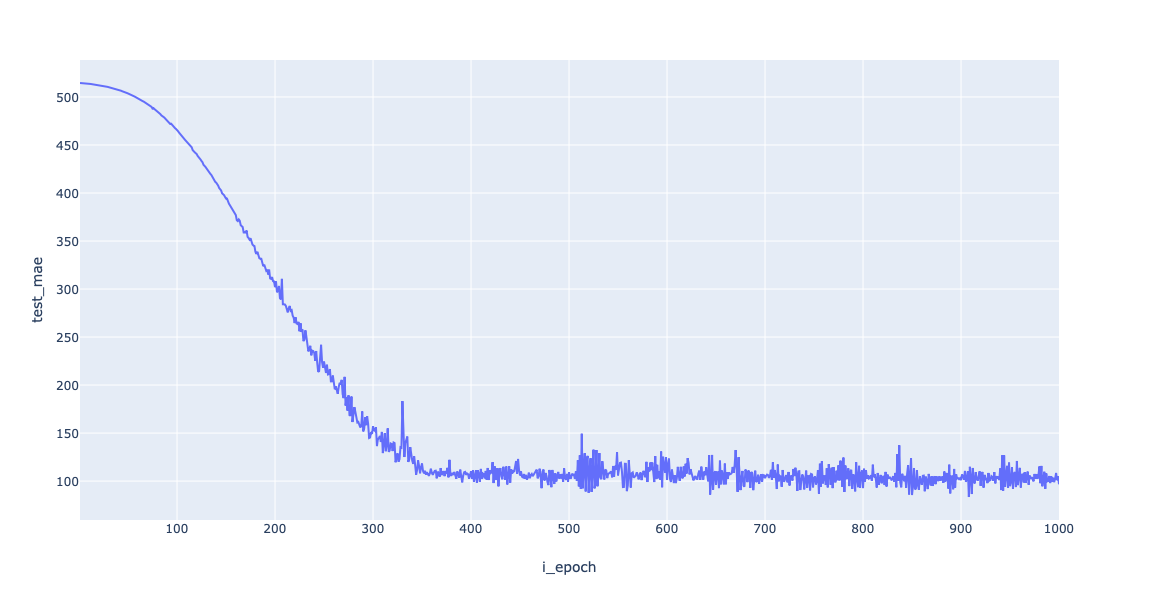

In [106]:
fig = px.line(trainer.losses, x='i_epoch', y='test_mae')
fig.show()


### model building with random hyper parameters

In [25]:
# --- import necessary libraries

from xenonpy.model.nn import Generator1d
from xenonpy.model.nn import wrap

# 3rd packages
from torch.nn import ReLU, Tanh
from math import ceil

In [26]:
# parameter scheduler
def scheduler(i, paras):
    n_out = max(ceil(paras['n_out'] * uniform(0.3, 0.8)),5)
    return dict(paras, n_out=n_out)

# model generator
generator = Generator1d(290, 1,  # num of input an output neuron
                n_neuron=[ceil(uniform(0.8, 1.0) * 150) for n in range(5)],  # variety of neuron num in each layer
                act_func=(ReLU(),),   # variety of activation function in each layer
                drop_out=(0.1,),  # variety of dropout rate in each layer
                batch_normalize=(wrap.L1.batch_norm(),)
               )

In [30]:
# --- generate models

models = generator(4, n_models=1, replace=True, scheduler=scheduler)

In [31]:
# --- check the model generator

models

<generator object Generator1d.__call__ at 0x1a48e97ca8>

In [32]:
model = list(models)[0]
model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=125, bias=True)
    (batch_nor): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=125, out_features=69, bias=True)
    (batch_nor): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=69, out_features=38, bias=True)
    (batch_nor): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=38, out_features=16, bias=True)
    (batch_nor): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Linear(in_features=16, out_features=1, bi